### Aziz Guergachi - Javed Hakim | GHICM Model Simulations

This article has one single purpose: introduce a new and simple, yet highly insightful approach to capture, fully and quantitatively, the dynamics of the circular flow of income in economies. The proposed approach relies mostly on basic linear algebraic concepts and has deep implications for the disciplines of economics, physics and econophysics.

#### **https://doi.org/10.48550/arXiv.2307.02713**

#### *https://github.com/taimuri99/GHICM-SIMULATION-CODE/tree/main*

### Imports and Setup

In [65]:
# Imports and Setup

import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix, diags
from scipy.stats import beta, pareto, truncnorm, maxwell, uniform, burr
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
import gc
from typing import Tuple, List, Optional
import warnings
import psutil
from tqdm import tqdm
import time

warnings.filterwarnings('ignore')

# Display options
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.max_columns', 10)
pd.set_option('display.precision', 3)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True

print("✅ All imports successful!")
print("Enhanced ICM System - Ready!")
print(f"Available RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")

✅ All imports successful!
Enhanced ICM System - Ready!
Available RAM: 8.0 GB


In [66]:
# Utility functions

def print_memory_usage(label=""):
    """Print current memory usage"""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / (1024 * 1024)
    available_gb = psutil.virtual_memory().available / (1024**3)
    print(f"{label} Memory usage: {memory_mb:.1f} MB | Available: {available_gb:.1f} GB")
    return memory_mb

def cleanup_memory():
    """Force garbage collection"""
    gc.collect()
    print("Memory cleaned up")

def format_number(num):
    """Format large numbers nicely"""
    if num >= 1e9:
        return f"{num/1e9:.1f}B"
    elif num >= 1e6:
        return f"{num/1e6:.1f}M"
    elif num >= 1e3:
        return f"{num/1e3:.1f}K"
    else:
        return str(int(num))

print("✅ Utility functions loaded!")

✅ Utility functions loaded!


### Distribution Generator

In [67]:
# Distribution Generator Class

class DistributionGenerator:
    """Generate various probability distributions for wealth modeling"""
    
    def __init__(self, seed: int):
        self.seed = seed
        np.random.seed(seed)
    
    def generate_boltzmann_gibbs(self, n: int, T: float = 100000, 
                                pareto_alpha: float = 1.5, pareto_fraction: float = 0.1) -> np.ndarray:
        """Boltzmann-Gibbs (exponential) with Pareto tail"""
        rate = 1 / T
        wealth = np.random.exponential(scale=1/rate, size=n)
        
        # Add Pareto tail for specified fraction
        num_high = int(pareto_fraction * n)
        if num_high > 0:
            pareto_wealth = np.random.pareto(pareto_alpha, size=num_high)
            wealth[:num_high] += pareto_wealth
        
        return wealth
    
    def generate_ccm(self, n: int, saving_propensity: float = 0.2, 
                     transactions: int = 50000) -> np.ndarray:
        """Chakraborti-Chakrabarti Model"""
        wealth = np.ones(n)
        
        for _ in range(transactions):
            i, j = np.random.choice(n, 2, replace=False)
            delta_w = (1 - saving_propensity) * (wealth[i] + wealth[j]) / 2
            wealth[i] = saving_propensity * wealth[i] + delta_w
            wealth[j] = saving_propensity * wealth[j] + delta_w
        
        # Add noise to break ties
        noise = np.random.uniform(0.001, 0.01, size=n) * np.mean(wealth)
        return wealth + noise
    
    def generate_pareto(self, n: int, alpha: float = 2.5) -> np.ndarray:
        """Pareto distribution"""
        return np.random.pareto(alpha, size=n)
    
    def generate_lognormal(self, n: int, sigma: float = 1.5, mu: float = 10) -> np.ndarray:
        """Lognormal distribution"""
        mu_log = np.log(mu) - 0.5 * sigma**2
        return np.random.lognormal(mu_log, sigma, size=n)
    
    def generate_gamma(self, n: int, mean_target: float = 10000, shape: float = 2.0) -> np.ndarray:
        """Gamma distribution"""
        scale = mean_target / shape
        return np.random.gamma(shape, scale, size=n)
    
    def generate_weibull(self, n: int, shape: float = 1.5) -> np.ndarray:
        """Weibull distribution"""
        return np.random.weibull(shape, size=n)
    
    def generate_beta(self, n: int, alpha: float = 0.4, beta_param: float = 0.6) -> np.ndarray:
        """Beta distribution"""
        return beta.rvs(alpha, beta_param, size=n)
    
    def generate_bose_einstein(self, n: int, T: float = 100000, mu: float = 0.0) -> np.ndarray:
        """Bose-Einstein distribution"""
        k = 1.0
        E = np.random.uniform(0.1, 10, size=n)
        exponent = np.clip((E - mu) / (k * T), -500, 500)
        wealth = 1 / (np.exp(exponent) - 1)
        return np.nan_to_num(wealth, nan=1.0, posinf=1000.0, neginf=0.0)
    
    def generate_random(self, n: int) -> np.ndarray:
        """Uniform random distribution"""
        return np.random.rand(n)
    
    def generate_distribution(self, n: int, model: str, **kwargs) -> np.ndarray:
        """Master function to generate any distribution"""
        distribution_map = {
            'random': self.generate_random,
            'boltzgibbs': self.generate_boltzmann_gibbs,
            'gamma': self.generate_gamma,
            'lognormal': self.generate_lognormal,
            'pareto': self.generate_pareto,
            'weibull': self.generate_weibull,
            'beta': self.generate_beta,
            'ccm': self.generate_ccm,
            'bose': self.generate_bose_einstein
        }
        
        if model not in distribution_map:
            raise ValueError(f"Invalid model: {model}. Available: {list(distribution_map.keys())}")
        
        return distribution_map[model](n, **kwargs)
    
    def normalize_and_scale(self, values: np.ndarray, lower_bound: float, 
                           upper_bound: float, sort_descending: bool = True) -> np.ndarray:
        """Normalize to [0,1] then scale to [lower_bound, upper_bound]"""
        if np.max(values) == np.min(values):
            return np.full_like(values, (lower_bound + upper_bound) / 2)
        
        normalized = (values - np.min(values)) / (np.max(values) - np.min(values))
        scaled = lower_bound + normalized * (upper_bound - lower_bound)
        
        if sort_descending:
            scaled = np.sort(scaled)[::-1]
        
        return scaled

print("✅ Distribution Generator ready - supports 9 different models")

✅ Distribution Generator ready - supports 9 different models


### Enhanced Wealth Generator

In [68]:
# Enhanced Wealth Generator

class EnhancedWealthGenerator:
    """Generate initial wealth distributions using any probability model"""
    
    def __init__(self, seed: int):
        self.dist_gen = DistributionGenerator(seed)
        self.seed = seed
    
    def generate_initial_wealth(self, n_agents: int, model: str,
                               lower_bound: float, upper_bound: float,
                               plot: bool = False, **model_kwargs) -> np.ndarray:
        """Generate initial wealth distribution"""
        
        print(f"Generating initial wealth for {format_number(n_agents)} agents using {model}")
        start_time = time.time()
        
        # Set seed for wealth generation
        np.random.seed(self.seed)
        
        # Generate raw distribution
        raw_wealth = self.dist_gen.generate_distribution(n_agents, model, **model_kwargs)
        
        # Scale to desired range with wealth hierarchy (richest first)
        initial_wealth = self.dist_gen.normalize_and_scale(
            raw_wealth, lower_bound, upper_bound, sort_descending=True
        )
        
        wealth_time = time.time() - start_time
        
        # Statistics
        print(f"Completed in {wealth_time:.2f}s")
        print(f"Range: ${initial_wealth.min():,.0f} - ${initial_wealth.max():,.0f}")
        print(f"Mean: ${np.mean(initial_wealth):,.0f}")
        print(f"Top 1%: ${np.percentile(initial_wealth, 99):,.0f}")
        print(f"Bottom 10%: ${np.percentile(initial_wealth, 10):,.0f}")
        
        # Optional plotting
        if plot:
            plt.figure(figsize=(10, 6))
            plt.hist(initial_wealth, bins=100, density=True, alpha=0.7, color='purple')
            plt.xlabel('Wealth ($)')
            plt.ylabel('Density')
            plt.title(f'Initial Wealth Distribution ({model})')
            plt.show()
        
        print_memory_usage("After wealth generation:")
        return initial_wealth
    
    def generate_savings_fractions(self, n_agents: int, model: str, **kwargs) -> np.ndarray:
        """Generate savings fractions for ICM diagonal elements"""
        # Ensure consistent seed usage
        np.random.seed(self.seed)
        raw_fractions = self.dist_gen.generate_distribution(n_agents, model, **kwargs)
        # Normalize to [0,1] and sort (wealthy save more)
        return self.dist_gen.normalize_and_scale(raw_fractions, 0.0, 1.0, sort_descending=True)
    
    def generate_income_fractions(self, n_agents: int, model: str, **kwargs) -> np.ndarray:
        """Generate income fractions for ICM off-diagonal elements"""
        # Ensure consistent seed usage
        np.random.seed(self.seed)
        raw_income = self.dist_gen.generate_distribution(n_agents, model, **kwargs)
        # Normalize to [0,1] without sorting (for interactions)
        return self.dist_gen.normalize_and_scale(raw_income, 0.0, 1.0, sort_descending=False)

print("✅ Wealth Generator ready")

✅ Wealth Generator ready


### Sparse ICM Generator

In [69]:
# Sparse ICM Generator

class EnhancedSparseICM:
    """Generate and evolve sparse Income Circulation Matrices"""
    
    def __init__(self, n_agents: int, interact_percent: float, 
                 chunk_size: int, seed: int, f0_seed: int):
        self.n = n_agents
        self.interact_percent = interact_percent
        self.chunk_size = min(chunk_size, n_agents)
        self.seed = seed
        self.f0_seed = f0_seed
        self.wealth_gen = EnhancedWealthGenerator(f0_seed)  # Use f0_seed for F0 generation
        self.n_interactions = int(n_agents * interact_percent / 100)
        
        print(f"Sparse ICM initialized: {format_number(n_agents)} agents, {interact_percent}% interactions")
    
    def generate_sparse_F0(self, saving_model: str, income_model: str) -> sparse.csr_matrix:
        """Generate initial sparse ICM matrix"""
        
        print(f"Generating sparse F0 matrix...")
        start_time = time.time()
        
        # Set F0 generation seed
        np.random.seed(self.f0_seed)
        
        # Generate savings fractions (diagonal elements)
        savings_fractions = self.wealth_gen.generate_savings_fractions(self.n, saving_model)
        
        # Prepare sparse matrix data
        row_indices = []
        col_indices = []
        data = []
        
        print(f"Generating F0 with {format_number(self.n)} agents, {self.interact_percent}% interaction rate...")
        
        # Add diagonal elements (savings)
        for i in range(self.n):
            row_indices.append(i)
            col_indices.append(i)
            data.append(savings_fractions[i])
        
        # Add off-diagonal interactions in chunks
        print("Adding interaction elements...")
        for chunk_start in tqdm(range(0, self.n, self.chunk_size)):
            chunk_end = min(chunk_start + self.chunk_size, self.n)
            self._add_chunk_interactions(chunk_start, chunk_end, savings_fractions, 
                                       income_model, row_indices, col_indices, data)
        
        # Create sparse matrix
        row_indices = np.array(row_indices, dtype=np.int32)
        col_indices = np.array(col_indices, dtype=np.int32)
        data = np.array(data, dtype=np.float64)
        
        F = sparse.csr_matrix((data, (row_indices, col_indices)), shape=(self.n, self.n))
        
        # Normalize columns to sum to 1
        F = self._normalize_columns_sparse(F)
        
        generation_time = time.time() - start_time
        print(f"F0 completed in {generation_time:.1f}s")
        print(f"Matrix: {F.shape}, Non-zeros: {F.nnz:,}, Density: {F.nnz/(F.shape[0]*F.shape[1]):.6f}")
        print(f"Memory: ~{(F.nnz * 16) / (1024**2):.0f} MB")
        
        return F
    
    def _add_chunk_interactions(self, chunk_start, chunk_end, savings_fractions, 
                               income_model, row_indices, col_indices, data):
        """Add interaction elements for a chunk of agents"""
        
        for j in range(chunk_start, chunk_end):
            if self.n_interactions > 0 and self.n_interactions < self.n - 1:
                # Select interacting agents (excluding self)
                available_agents = np.arange(self.n)
                available_agents = available_agents[available_agents != j]
                
                n_select = min(self.n_interactions, len(available_agents))
                selected_agents = np.random.choice(available_agents, n_select, replace=False)
                
                # Generate income fractions
                income_fractions = self.wealth_gen.generate_income_fractions(len(selected_agents), income_model)
                income_fractions /= income_fractions.sum()  # Normalize
                income_fractions *= (1 - savings_fractions[j])  # Scale by remaining wealth
                
                # Add to sparse matrix
                for i, weight in zip(selected_agents, income_fractions):
                    row_indices.append(i)
                    col_indices.append(j)
                    data.append(weight)
    
    def _normalize_columns_sparse(self, F: sparse.csr_matrix) -> sparse.csr_matrix:
        """Normalize columns to sum to 1"""
        F_csc = F.tocsc()
        
        col_sums = np.array(F_csc.sum(axis=0)).flatten()
        col_sums[col_sums == 0] = 1e-8  # Prevent zero columns
        
        col_sums_diag = sparse.diags(1.0 / col_sums, format='csr')
        F_normalized = F_csc @ col_sums_diag
        
        return F_normalized.tocsr()
    
    def evolve_sparse_F(self, F_prev: sparse.csr_matrix, a_percent: float,
                       b_percent: float, c_percent: float, ft_seed: int, step: int) -> sparse.csr_matrix:
        """Evolve sparse ICM matrix"""
        
        # Use ft_seed with step offset for evolution
        np.random.seed(ft_seed + step)
        
        F_new = F_prev.copy()
        
        # Select columns to modify
        n_cols_modify = max(1, int(a_percent * self.n / 100))
        cols_to_modify = np.random.choice(self.n, n_cols_modify, replace=False)
        
        for j in cols_to_modify:
            col_data = F_new.getcol(j).toarray().flatten()
            non_zero_indices = np.nonzero(col_data)[0]
            
            if len(non_zero_indices) > 0:
                n_elements_modify = max(1, int(b_percent * len(non_zero_indices) / 100))
                elements_to_modify = np.random.choice(non_zero_indices, 
                                                    min(n_elements_modify, len(non_zero_indices)), 
                                                    replace=False)
                
                for i in elements_to_modify:
                    change = np.random.uniform(-c_percent / 100, c_percent / 100)
                    new_value = max(0, min(1, col_data[i] + change))
                    F_new[i, j] = new_value
        
        # Re-normalize modified columns
        for j in cols_to_modify:
            col_sum = F_new[:, j].sum()
            if col_sum > 0:
                F_new[:, j] /= col_sum
        
        return F_new

print("✅ Sparse ICM Generator ready")

✅ Sparse ICM Generator ready


### Simulation Engine

In [70]:
# Wealth Simulation Engine

class WealthSimulationEngine:
    """Memory-efficient wealth simulation with injection capabilities"""
    
    def __init__(self, icm_generator: EnhancedSparseICM):
        self.icm = icm_generator
        self.n = icm_generator.n
    
    def apply_wealth_injection(self, X: np.ndarray, top_percent: float ,
                             bottom_percent: float, 
                             injection_percent: float) -> np.ndarray:
        """Transfer wealth from top percentile to bottom percentile"""
        
        X_new = X.copy().astype(float)
        
        # Calculate agent counts
        top_k = int(np.ceil(top_percent / 100 * self.n))
        bottom_k = int(np.ceil(bottom_percent / 100 * self.n))
        
        # Calculate total injection amount
        total_injection = np.sum(X_new[:top_k]) * (injection_percent / 100)
        
        # Remove from top agents
        X_new[:top_k] *= (1 - injection_percent / 100)
        
        # Distribute equally to bottom agents
        injection_per_agent = total_injection / bottom_k
        X_new[-bottom_k:] += injection_per_agent
        
        return X_new
    
    def simulate_wealth_evolution(self, X0: np.ndarray, F0: sparse.csr_matrix,
                                 n_steps: int, a_percent: float, b_percent: float, 
                                 c_percent: float, ft_seed: int, injection_config: dict = None) -> tuple:
        """
        Run complete wealth simulation with optional injection
        
        Returns: (wealth_no_injection, wealth_with_injection)
        """
        
        print(f"Starting simulation: {format_number(self.n)} agents, {n_steps} steps")
        print(f"Evolution params: a={a_percent}%, b={b_percent}%, c={c_percent}%")
        
        # Initialize tracking
        wealth_no_injection = [X0.copy()]
        wealth_with_injection = [X0.copy()] if injection_config else None
        
        # Current states
        X_current = X0.copy()
        X_injection_current = X0.copy() if injection_config else None
        F_current = F0
        
        start_time = time.time()
        
        for t in tqdm(range(1, n_steps + 1), desc="Simulating"):
            # Evolve ICM matrix (except first step)
            if t > 1:
                F_current = self.icm.evolve_sparse_F(
                    F_current, a_percent, b_percent, c_percent, ft_seed, t
                )
            
            # Apply wealth injection if configured
            if injection_config and t == injection_config.get('injection_step', 20):
                print(f"Applying {injection_config['injection_percent']}% wealth injection at step {t}")
                X_injection_current = self.apply_wealth_injection(
                    X_injection_current,
                    top_percent=injection_config['top_percent'],
                    bottom_percent=injection_config['bottom_percent'], 
                    injection_percent=injection_config['injection_percent']
                )
            
            # Evolve wealth vectors using matrix multiplication
            X_current = F_current @ X_current
            if injection_config:
                X_injection_current = F_current @ X_injection_current
            
            # Store results
            wealth_no_injection.append(X_current.copy())
            if injection_config:
                wealth_with_injection.append(X_injection_current.copy())
            
            # Periodic memory cleanup
            if t % 20 == 0:
                gc.collect()
        
        simulation_time = time.time() - start_time
        print(f"Simulation completed in {simulation_time:.1f}s")
        print(f"Performance: {format_number(self.n * n_steps / simulation_time)} agent-steps/second")
        
        return wealth_no_injection, wealth_with_injection

print("✅ Simulation Engine ready")

✅ Simulation Engine ready


### Analysis Tools

In [71]:
# Wealth Analysis Tools

class WealthAnalyzer:
    """Analyze wealth distributions and policy impacts"""
    
    def analyze_wealth_distribution(self, X_matrices: list,
                                   top_percent: float, 
                                   bottom_percent: float) -> pd.DataFrame:
        """Analyze wealth distribution evolution over time"""
        
        results = []
        n = len(X_matrices[0])
        
        for t, X in enumerate(X_matrices):
            top_k = int(np.ceil(top_percent / 100 * n))
            bottom_k = int(np.ceil(bottom_percent / 100 * n))
            
            top_wealth = np.sum(X[:top_k])
            bottom_wealth = np.sum(X[-bottom_k:])
            total_wealth = np.sum(X)
            
            results.append({
                'step': t,
                'top_wealth': top_wealth,
                'bottom_wealth': bottom_wealth,
                'total_wealth': total_wealth,
                'top_ratio': top_wealth / total_wealth,
                'bottom_ratio': bottom_wealth / total_wealth,
                'inequality_ratio': top_wealth / bottom_wealth if bottom_wealth > 0 else np.inf,
                'gini_coefficient': self._calculate_gini(X)
            })
        
        return pd.DataFrame(results)
    
    def _calculate_gini(self, wealth: np.ndarray) -> float:
        """Calculate Gini coefficient for inequality measurement"""
        if len(wealth) == 0 or np.sum(wealth) == 0:
            return 0.0
        
        sorted_wealth = np.sort(wealth)
        n = len(wealth)
        index = np.arange(1, n + 1)
        return (2 * np.sum(index * sorted_wealth)) / (n * np.sum(sorted_wealth)) - (n + 1) / n
    
    def compare_scenarios(self, results_no_inj: pd.DataFrame, 
                         results_with_inj: pd.DataFrame) -> dict:
        """Compare scenarios with and without wealth injection"""
        
        final_no_inj = results_no_inj.iloc[-1]
        final_with_inj = results_with_inj.iloc[-1]
        
        comparison = {
            'top_wealth_reduction_pct': (final_no_inj['top_ratio'] - final_with_inj['top_ratio']) / final_no_inj['top_ratio'] * 100,
            'bottom_wealth_increase_pct': (final_with_inj['bottom_ratio'] - final_no_inj['bottom_ratio']) / final_no_inj['bottom_ratio'] * 100,
            'inequality_reduction': final_no_inj['inequality_ratio'] - final_with_inj['inequality_ratio'],
            'gini_improvement': final_no_inj['gini_coefficient'] - final_with_inj['gini_coefficient'],
            'final_top_ratio_no_inj': final_no_inj['top_ratio'],
            'final_top_ratio_with_inj': final_with_inj['top_ratio'],
            'final_bottom_ratio_no_inj': final_no_inj['bottom_ratio'],
            'final_bottom_ratio_with_inj': final_with_inj['bottom_ratio']
        }
        
        return comparison
    
    def plot_results(self, df_no_inj: pd.DataFrame, df_with_inj: pd.DataFrame,
                    injection_step: int, top_percent: float,
                    bottom_percent: float):
        """Plot comprehensive wealth evolution analysis"""
        
        has_injection = df_with_inj is not None
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Top wealth evolution
        axes[0,0].plot(df_no_inj['step'], df_no_inj['top_wealth'], 
                      label='No Injection', color='teal', linewidth=2)
        if has_injection:
            axes[0,0].plot(df_with_inj['step'], df_with_inj['top_wealth'],
                          label='With Injection', color='orange', linewidth=2)
        
        if injection_step:
            axes[0,0].axvline(injection_step, color='red', linestyle='--', alpha=0.7)
        
        axes[0,0].set_title(f'Top {top_percent}% Wealth Evolution')
        axes[0,0].set_ylabel('Total Wealth')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Bottom wealth evolution  
        axes[0,1].plot(df_no_inj['step'], df_no_inj['bottom_wealth'],
                      label='No Injection', color='teal', linewidth=2)
        if has_injection:
            axes[0,1].plot(df_with_inj['step'], df_with_inj['bottom_wealth'],
                          label='With Injection', color='orange', linewidth=2)
            
        if injection_step:
            axes[0,1].axvline(injection_step, color='red', linestyle='--', alpha=0.7)
        
        axes[0,1].set_title(f'Bottom {bottom_percent}% Wealth Evolution')
        axes[0,1].set_ylabel('Total Wealth')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Inequality ratio
        axes[1,0].plot(df_no_inj['step'], df_no_inj['inequality_ratio'],
                      label='No Injection', color='teal', linewidth=2)
        if has_injection:
            axes[1,0].plot(df_with_inj['step'], df_with_inj['inequality_ratio'],
                          label='With Injection', color='orange', linewidth=2)
            
        if injection_step:
            axes[1,0].axvline(injection_step, color='red', linestyle='--', alpha=0.7)
        
        axes[1,0].set_title('Inequality Ratio (Top/Bottom)')
        axes[1,0].set_ylabel('Ratio')
        axes[1,0].set_xlabel('Time Step')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Gini coefficient
        axes[1,1].plot(df_no_inj['step'], df_no_inj['gini_coefficient'],
                      label='No Injection', color='teal', linewidth=2)
        if has_injection:
            axes[1,1].plot(df_with_inj['step'], df_with_inj['gini_coefficient'],
                          label='With Injection', color='orange', linewidth=2)
            
        if injection_step:
            axes[1,1].axvline(injection_step, color='red', linestyle='--', alpha=0.7)
        
        axes[1,1].set_title('Gini Coefficient Evolution')
        axes[1,1].set_ylabel('Gini Coefficient')
        axes[1,1].set_xlabel('Time Step')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.suptitle(f'ICM Analysis: {top_percent}% Top vs {bottom_percent}% Bottom', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def print_summary(self, comparison: dict, top_percent: float, bottom_percent: float):
        """Print summary of policy impact"""
        print(f"\nPOLICY IMPACT SUMMARY:")
        print(f"{'Metric':<30} {'Value':<15}")
        print("-" * 45)
        print(f"{'Top '+str(int(top_percent))+'% wealth reduction':<30} {comparison['top_wealth_reduction_pct']:.1f}%")
        print(f"{'Bottom '+str(int(bottom_percent))+'% wealth increase':<30} {comparison['bottom_wealth_increase_pct']:.1f}%") 
        print(f"{'Inequality reduction':<30} {comparison['inequality_reduction']:.2f}")
        print(f"{'Gini improvement':<30} {comparison['gini_improvement']:.4f}")
        print(f"{'Final top ratio (no inj)':<30} {comparison['final_top_ratio_no_inj']:.3f}")
        print(f"{'Final top ratio (with inj)':<30} {comparison['final_top_ratio_with_inj']:.3f}")
        print(f"{'Final bottom ratio (no inj)':<30} {comparison['final_bottom_ratio_no_inj']:.3f}")
        print(f"{'Final bottom ratio (with inj)':<30} {comparison['final_bottom_ratio_with_inj']:.3f}")

print("✅ Analysis Tools ready")

✅ Analysis Tools ready


### Main Enhanced ICM Class

In [72]:
# Main Enhanced ICM System

class EnhancedScalableICM:
    """
    Main class that combines all components for scalable ICM simulations
    """
    
    def __init__(self, n_agents: int, interact_percent: float, 
                 chunk_size: int, seed: int, f0_seed: int):
        
        self.n = n_agents
        self.interact_percent = interact_percent
        self.seed = seed
        self.f0_seed = f0_seed
        
        # Initialize all components
        self.icm_generator = EnhancedSparseICM(n_agents, interact_percent, chunk_size, seed, f0_seed)
        self.wealth_gen = EnhancedWealthGenerator(seed)
        self.simulator = WealthSimulationEngine(self.icm_generator)
        self.analyzer = WealthAnalyzer()
        
        print(f"Enhanced ICM System Ready:")
        print(f"  Agents: {format_number(n_agents)}")
        print(f"  Interaction rate: {interact_percent}%")
        print(f"  Expected interactions per agent: {int(n_agents * interact_percent / 100)}")
    
    def estimate_memory_usage(self, n_timesteps: int) -> dict:
        """Estimate memory requirements"""
        
        # Matrix density calculation
        interaction_density = self.interact_percent / 100
        diagonal_density = 1 / self.n
        total_density = interaction_density + diagonal_density
        
        # Sparse matrix memory
        nnz = int(total_density * self.n * self.n)
        sparse_matrix_mb = (nnz * 16) / (1024**2)  # data + indices
        
        # Wealth vectors
        wealth_vector_mb = (self.n * 8) / (1024**2)
        
        # Working memory (current state only)
        working_memory_mb = sparse_matrix_mb + wealth_vector_mb * 3
        
        return {
            'agents': format_number(self.n),
            'density': f"{total_density:.6%}",
            'non_zero_elements': format_number(nnz),
            'sparse_matrix_mb': sparse_matrix_mb,
            'wealth_vectors_mb': wealth_vector_mb * 3,
            'working_memory_mb': working_memory_mb,
            'working_memory_gb': working_memory_mb / 1024,
            'feasible': working_memory_mb < 8000  # Less than 8GB
        }
    
    def run_simulation(self, config) -> dict:
        """
        Run complete ICM simulation using config object
        
        Returns dictionary with all results and analysis
        """
        
        print("=" * 60)
        print("ENHANCED ICM SIMULATION")
        print("=" * 60)
        
        # Memory check
        memory_info = self.estimate_memory_usage(config.S)
        print(f"Memory estimate: {memory_info['working_memory_gb']:.2f} GB")
        
        if not memory_info['feasible']:
            print("WARNING: High memory usage expected!")
        
        results = {}
        
        # 1. Generate initial wealth
        print(f"\n1. GENERATING INITIAL WEALTH ({config.initial_wealth_model})")
        X0 = self.wealth_gen.generate_initial_wealth(
            config.n, config.initial_wealth_model, 
            config.lower_bound, config.upper_bound,
            plot=False
        )
        results['initial_wealth'] = X0
        
        # 2. Generate initial ICM
        print(f"\n2. GENERATING SPARSE ICM (savings: {config.saving_distribution}, income: {config.income_distribution})")
        F0 = self.icm_generator.generate_sparse_F0(config.saving_distribution, config.income_distribution)
        results['initial_matrix'] = F0
        
        # 3. Configure injection
        injection_config = {
            'injection_step': config.injection_step,
            'injection_percent': config.injection_percent,
            'top_percent': config.top_percent,
            'bottom_percent': config.bottom_percent
        }
        
        # 4. Run simulation
        print(f"\n3. RUNNING SIMULATION ({config.S} steps)")
        wealth_no_inj, wealth_with_inj = self.simulator.simulate_wealth_evolution(
            X0, F0, config.S, config.a, config.b, config.c, config.ft_seed, injection_config
        )
        
        # 5. Analyze results
        print("\n4. ANALYZING RESULTS")
        df_no_inj = self.analyzer.analyze_wealth_distribution(
            wealth_no_inj, config.top_percent, config.bottom_percent
        )
        results['analysis_no_injection'] = df_no_inj
        
        if wealth_with_inj:
            df_with_inj = self.analyzer.analyze_wealth_distribution(
                wealth_with_inj, config.top_percent, config.bottom_percent
            )
            results['analysis_with_injection'] = df_with_inj
            
            # Compare scenarios
            comparison = self.analyzer.compare_scenarios(df_no_inj, df_with_inj)
            results['policy_comparison'] = comparison
            
            self.analyzer.print_summary(comparison, config.top_percent, config.bottom_percent)
        else:
            df_with_inj = None
            comparison = None
        
        # 6. Plot results
        print("\n5. GENERATING PLOTS")
        self.analyzer.plot_results(
            df_no_inj, df_with_inj, 
            config.injection_step,
            config.top_percent, config.bottom_percent
        )
        
        # Store configuration
        results['configuration'] = {
            'n_agents': self.n,
            'interact_percent': self.interact_percent,
            'config': config.__dict__.copy(),
            'memory_info': memory_info
        }
        
        print("\n" + "=" * 60)
        print("SIMULATION COMPLETE")
        print("=" * 60)
        
        return results

print("✅ Main Enhanced ICM System ready for simulation!")

✅ Main Enhanced ICM System ready for simulation!


### SIMULATION CONFIGURATION

In [73]:
class SimulationConfig:
    def __init__(self):
        # Your parameters
        self.interact = 0.5
        self.a = 2
        self.b = 2  
        self.c = 2
        self.n = 5000
        self.initial_wealth_model = "boltzgibbs"
        self.saving_distribution = "random"
        self.income_distribution = "bose"
        self.lower_bound = 1000
        self.upper_bound = 100000000
        self.top_percent = 10
        self.bottom_percent = 40
        self.seed = 8556
        self.f0_seed = 4720
        self.ft_seed = 8976
        self.S = 50
        self.injection_step = 20
        self.injection_percent = 15
        self.tc = self.interact
        self.bc = 25

print("✅ Main Simulation Configuration established!")

✅ Main Simulation Configuration established!


### SIMULATION FUNCTIONALS

In [74]:
def run_ghicm(config):
    icm_system = EnhancedScalableICM(
        n_agents=config.n,
        interact_percent=config.interact,
        chunk_size=10000,
        seed=config.seed,
        f0_seed=config.f0_seed
    )
    
    results = icm_system.run_simulation(config)
    return results

print("✅ Simulation optimized with Configuration Settings!")

✅ Simulation optimized with Configuration Settings!


### ANALYSIS

Sparse ICM initialized: 5.0K agents, 0.5% interactions
Enhanced ICM System Ready:
  Agents: 5.0K
  Interaction rate: 0.5%
  Expected interactions per agent: 25
ENHANCED ICM SIMULATION
Memory estimate: 0.00 GB

1. GENERATING INITIAL WEALTH (boltzgibbs)
Generating initial wealth for 5.0K agents using boltzgibbs
Completed in 0.02s
Range: $1,000 - $100,000,000
Mean: $11,790,569
Top 1%: $52,557,849
Bottom 10%: $1,212,551
After wealth generation: Memory usage: 24.5 MB | Available: 0.4 GB

2. GENERATING SPARSE ICM (savings: random, income: bose)
Generating sparse F0 matrix...
Generating F0 with 5.0K agents, 0.5% interaction rate...
Adding interaction elements...


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


F0 completed in 0.7s
Matrix: (5000, 5000), Non-zeros: 124,975, Density: 0.004999
Memory: ~2 MB

3. RUNNING SIMULATION (50 steps)
Starting simulation: 5.0K agents, 50 steps
Evolution params: a=2%, b=2%, c=2%


Simulating:  38%|███▊      | 19/50 [00:01<00:02, 14.17it/s]

Applying 15% wealth injection at step 20


Simulating: 100%|██████████| 50/50 [00:04<00:00, 12.50it/s]


Simulation completed in 4.0s
Performance: 62.5K agent-steps/second

4. ANALYZING RESULTS

POLICY IMPACT SUMMARY:
Metric                         Value          
---------------------------------------------
Top 10% wealth reduction       6.5%
Bottom 40% wealth increase     1.4%
Inequality reduction           0.36
Gini improvement               -0.0004
Final top ratio (no inj)       0.200
Final top ratio (with inj)     0.187
Final bottom ratio (no inj)    0.043
Final bottom ratio (with inj)  0.044

5. GENERATING PLOTS


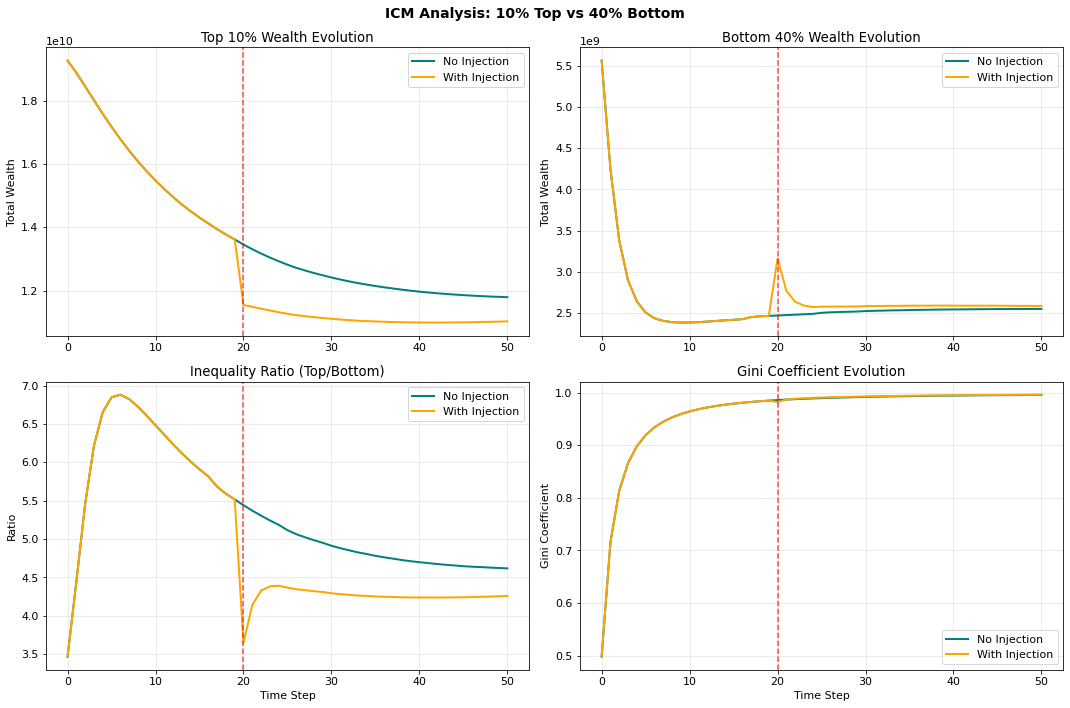


SIMULATION COMPLETE


In [75]:
# Set your parameters
config = SimulationConfig()

# Run simulation
results = run_ghicm(config)